## [Bayesian Regression - Introduction](http://pyro.ai/examples/bayesian_regression.html#Bayesian-Regression---Introduction-(Part-1))

In [1]:
import os

In [2]:
import numpy as np
import pandas as pd

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
import torch
import pyro

In [5]:
from functools import partial

In [6]:
import pyro.distributions as dist

In [7]:
DATA_URL = "https://d2hg8soec8ck9v.cloudfront.net/datasets/rugged_data.csv"
data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")
df = data[["cont_africa", "rugged", "rgdppc_2000"]]
df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])

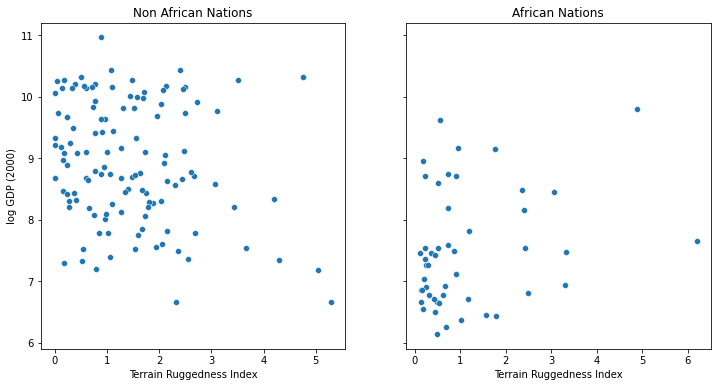

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = df[df["cont_africa"] == 1]
non_african_nations = df[df["cont_africa"] == 0]
sns.scatterplot(x=non_african_nations["rugged"],
                y=non_african_nations["rgdppc_2000"],
                ax=ax[0])
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
sns.scatterplot(x=african_nations["rugged"],
                y=african_nations["rgdppc_2000"],
                ax=ax[1])
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");

In [10]:
from torch import nn
from pyro.nn import PyroModule

In [12]:
assert issubclass(PyroModule[nn.Linear], nn.Linear)
assert issubclass(PyroModule[nn.Linear], PyroModule)

In [13]:
df["cont_africa_x_rugged"] = df["cont_africa"] * df["rugged"]

data = torch.tensor(df[["cont_africa", "rugged", "cont_africa_x_rugged", "rgdppc_2000"]].values,
                        dtype=torch.float)
x_data, y_data = data[:, :-1], data[:, -1]

In [14]:
x_data.shape

torch.Size([170, 3])

In [15]:
y_data.shape

torch.Size([170])

In [16]:
lr_model = PyroModule[nn.Linear](3,1)

In [18]:
loss_fn = torch.nn.MSELoss(reduction='sum')
optim = torch.optim.Adam(lr_model.parameters(), lr=0.05)
num_iterations = 1500

In [20]:
def train():
    y_pred = lr_model(x_data).squeeze(-1)
    loss = loss_fn(y_pred, y_data)
    optim.zero_grad()
    loss.backward()
    optim.step()
    return loss

In [21]:
for j in range(num_iterations):
    loss = train()
    if (j+1) % 50 == 0:
        print("[iteration %04d] loss: %.4f" % (j+1, loss.item()))

[iteration 0050] loss: 3684.2046
[iteration 0100] loss: 1927.5250
[iteration 0150] loss: 1302.5173
[iteration 0200] loss: 970.7817
[iteration 0250] loss: 744.4933
[iteration 0300] loss: 573.5540
[iteration 0350] loss: 443.0367
[iteration 0400] loss: 346.1815
[iteration 0450] loss: 276.9425
[iteration 0500] loss: 229.2698
[iteration 0550] loss: 197.6198
[iteration 0600] loss: 177.3393
[iteration 0650] loss: 164.7881
[iteration 0700] loss: 157.2830
[iteration 0750] loss: 152.9459
[iteration 0800] loss: 150.5234
[iteration 0850] loss: 149.2157
[iteration 0900] loss: 148.5335
[iteration 0950] loss: 148.1897
[iteration 1000] loss: 148.0223
[iteration 1050] loss: 147.9437
[iteration 1100] loss: 147.9080
[iteration 1150] loss: 147.8924
[iteration 1200] loss: 147.8858
[iteration 1250] loss: 147.8832
[iteration 1300] loss: 147.8821
[iteration 1350] loss: 147.8817
[iteration 1400] loss: 147.8816
[iteration 1450] loss: 147.8815
[iteration 1500] loss: 147.8815


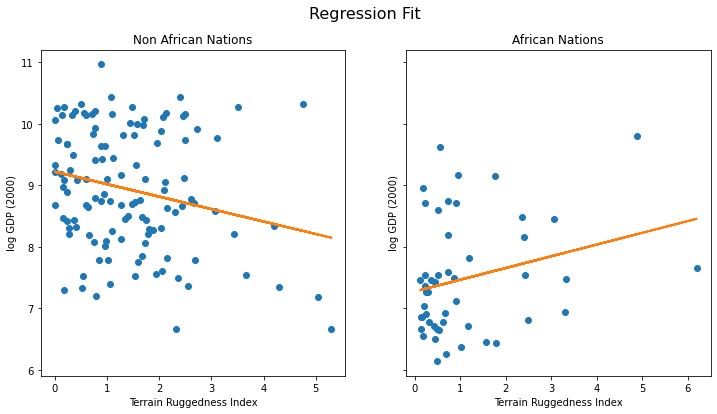

In [23]:
fit = df.copy()
fit["mean"] = lr_model(x_data).detach().cpu().numpy()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = fit[fit["cont_africa"] == 1]
non_african_nations = fit[fit["cont_africa"] == 0]
fig.suptitle("Regression Fit", fontsize=16)
ax[0].plot(non_african_nations["rugged"], non_african_nations["rgdppc_2000"], "o")
ax[0].plot(non_african_nations["rugged"], non_african_nations["mean"], linewidth=2)
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
ax[1].plot(african_nations["rugged"], african_nations["rgdppc_2000"], "o")
ax[1].plot(african_nations["rugged"], african_nations["mean"], linewidth=2)
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");

### Bayesian Regression Model

In [24]:
from pyro.nn import PyroSample

In [32]:
class BR(PyroModule):
    def __init__(self, in_features, out_target):
        super().__init__()
        self.linear = PyroModule[nn.Linear](in_features, out_target)
        # The BayesianRegression module internally uses the same PyroModule[nn.Linear] module. 
        # However, note that we replace the weight and the bias of the this module with PyroSample statements. 
        # These statements allow us to place a prior over the weight and bias parameters, 
        # instead of treating them as fixed learnable parameters. For the bias component, 
        # we set a reasonably wide prior since it is likely to be substantially above 0.
        self.linear.weight = PyroSample(dist.Normal(0.0,1.).expand([out_target, in_features]).to_event(2))
        self.linear.bias = PyroSample(dist.Normal(0., 10.).expand([out_target]).to_event(1))

    def forward(self, x, y=None):
        sigma = pyro.sample("sigma", dist.Uniform(0.,10.))
        mean = self.linear(x).squeeze(-1)
        with pyro.plate("data", x.shape[0]):
            # we use the obs argument to the pyro.sample statement to condition on the observed data y_data 
            # with a learned observation noise sigma
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        return mean

 Gaussian with diagonal covariance, i.e. it assumes that there is no correlation amongst the latent variables (quite a strong modeling assumption as we shall see i

In [30]:
from pyro.infer.autoguide import AutoDiagonalNormal

In [33]:
model = BR(3,1)
guide = AutoDiagonalNormal(model)

In [34]:
from pyro.infer import SVI, Trace_ELBO

In [37]:
adam = pyro.optim.Adam({"lr":0.03})
svi = SVI(model, guide, adam, loss=Trace_ELBO())

In [39]:
pyro.clear_param_store()

for j in range(1000):
    loss = svi.step(x_data, y_data)
    if j % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (j+1, loss / (len(data))))

[iteration 0001] loss: 3.0207
[iteration 0101] loss: 2.4662
[iteration 0201] loss: 1.8007
[iteration 0301] loss: 1.4621
[iteration 0401] loss: 1.4833
[iteration 0501] loss: 1.4883
[iteration 0601] loss: 1.4623
[iteration 0701] loss: 1.4620
[iteration 0801] loss: 1.4679
[iteration 0901] loss: 1.4948


In [40]:
guide.requires_grad_(False)

AutoDiagonalNormal()

In [41]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

AutoDiagonalNormal.loc Parameter containing:
tensor([-2.2760, -1.8333, -0.1607,  0.3765,  9.1763])
AutoDiagonalNormal.scale tensor([0.0568, 0.1417, 0.0417, 0.0739, 0.0644])


In [42]:
guide.quantiles([0.25, 0.5, 0.75])

{'sigma': tensor([0.8994, 0.9313, 0.9641]),
 'linear.weight': tensor([[[-1.9289, -0.1888,  0.3266]],
 
         [[-1.8333, -0.1607,  0.3765]],
 
         [[-1.7378, -0.1326,  0.4263]]]),
 'linear.bias': tensor([[9.1328],
         [9.1763],
         [9.2197]])}

### Model Evaluation